# Compute similarity to healthy for each time point using classifiers 

In [21]:
import importlib 
import util, models, training, eval

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)
importlib.reload(eval)

from data import PlateDataset
from util import torch_random_choice
from models import GatedAttentionMulti, GatedAttention
from eval import eval_model_on_dataset

In [ ]:
import torch
from torch.utils.data import Subset, TensorDataset
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler


device = 'cuda:6'

In [12]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], load_masks=True, load_chrometrics=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:56<00:00,  3.55s/it]


In [5]:
from torchvision.models import resnet18 as make_resnet18
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import DataLoader


def extract_resnet_patch_features(imgs, transform=None):
  model = make_resnet18(weights="DEFAULT").to(device)
  return_nodes = {
      'flatten': 'z',
  }
  feature_extractor = create_feature_extractor(model.eval().to(device), return_nodes=return_nodes)
  z = torch.zeros((len(imgs), 512))
  i = 0
  loader = DataLoader(imgs, batch_size=128, shuffle=False)
  # for batch in tqdm(loader):
  for img_batch in tqdm(loader):
    img_batch = img_batch.to(device).repeat(1, 3, 1, 1)
    if transform is not None:
      img_batch = transform(img_batch)
    with torch.no_grad():
      z[i:i+len(img_batch)] = feature_extractor(img_batch)['z'].cpu()
    i += len(img_batch)
  return z


res_zs = extract_resnet_patch_features(data.imgs)
res_zs.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8547/8547 [00:30<00:00, 281.10it/s]


torch.Size([1093966, 512])

plate  patient  time
5      P12      5          1
1      P68      5          3
       P51      3          8
15     P26      1          9
2      P16      3         14
                        ... 
13     P20      1       7130
12     P80      5       7207
       P118     2       8163
4      P145     5       8294
14     P19      5       8520
Name: cell, Length: 747, dtype: int64

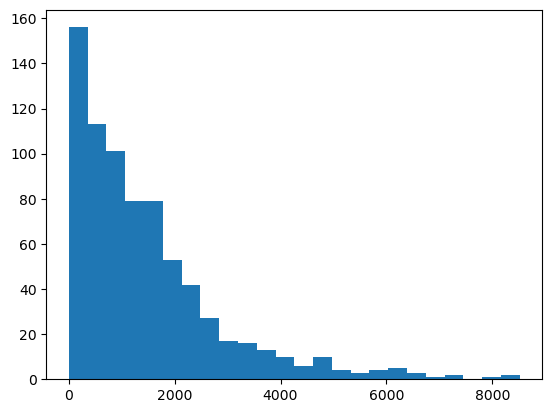

In [6]:
counts = data.info.groupby(['plate', 'patient', 'time'])['cell'].count().sort_values()
plt.hist(counts.values, bins=24)
counts

In [7]:
counts = counts.reset_index()

In [22]:
def eval_time_points(model, plate, device=device, m=100, features=None, data=data, counts=counts, resnet=False, mask=False):
  model.to(device).eval()

  labels = torch.from_numpy((data.info['group'] == 'healthy').values.astype(int))
  if features is None and mask:
    full_dataset = TensorDataset(T.CenterCrop(28)(data.imgs * data.masks), labels)
  elif features is None:
    full_dataset = TensorDataset(T.CenterCrop(28)(data.imgs), labels)
  else:
    full_dataset = TensorDataset(features, labels)

  patients = counts[(counts['plate'] == plate)]['patient'].unique()
  res = []
  for p in patients:
    for t in [0, 1, 2, 3, 4, 5]:
      pcounts = counts[counts['plate'] == plate].set_index(['patient', 'time'])
      if (p, t) not in pcounts.index or pcounts.loc[(p, t)]['cell'] < m:
        continue
      test_idx = np.argwhere(((data.info['time'] == t) & (data.info['patient'] == p)).values).flatten()
      test_dataset = Subset(full_dataset, test_idx)
      preds, _ = eval_model_on_dataset(model, test_dataset, device=device, resnet=resnet)
      res.append((p, t, (preds > 0.5).sum() / len(preds)))

  res = pd.DataFrame(res, columns=['patient', 'time', 'pred H %'])
  res['plate'] = plate
  healthy_mean = res[res['time'] == 0]['pred H %'].mean()
  res['score'] = res['pred H %'] / healthy_mean
  return res

## Chrometric, strict

In [17]:
chrometrics = data.chrometrics.values
use_cols = ~(np.isnan(chrometrics).any(axis=0) | np.isinf(chrometrics).any(axis=0))
chrometrics = StandardScaler().fit_transform(chrometrics[:, use_cols])
chrometrics = torch.from_numpy(chrometrics).float()
chrometrics.shape

torch.Size([1093966, 182])

In [18]:
from models import FeatClassifier

results = []
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for plate in tqdm(plates):
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_chrometrics'
    model = FeatClassifier(input_dim=182)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    results.append(eval_time_points(model, plate, features=chrometrics))

results = pd.concat(results)
results.to_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_chrometrics_scores.csv')
results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.03s/it]


,patient,time,pred H %,plate,score
0,P68,1,0.132668,1,0.302115
1,P68,2,0.481541,1,1.096580
2,P68,3,0.183062,1,0.416876
3,P68,4,0.260762,1,0.593816
4,P51,1,0.524336,1,1.194035
...,...,...,...,...,...
32,P45,3,0.023704,16,0.062327
33,P45,4,0.031638,16,0.083190
34,P45,5,0.038334,16,0.100797
35,H13,0,0.544248,16,1.431050


## Pretrained ResNet-18, strict

In [28]:
from models import FeatClassifier

results = []
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for plate in tqdm(plates):
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_resnet'
    model = FeatClassifier()
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    results.append(eval_time_points(model, plate, features=res_zs))

results = pd.concat(results)
results.to_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_pretrained_resnet_scores.csv')
results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:30<00:00,  9.43s/it]


,patient,time,pred H %,plate,score
0,P68,1,0.125535,1,0.179715
1,P68,2,0.438202,1,0.627327
2,P68,3,0.154833,1,0.221658
3,P68,4,0.334510,1,0.478881
4,P51,1,0.382743,1,0.547932
...,...,...,...,...,...
32,P45,3,0.005926,16,0.026668
33,P45,4,0.002260,16,0.010170
34,P45,5,0.007270,16,0.032718
35,H13,0,0.478319,16,2.152520


## Simple conv-net, strict

In [39]:
from models import Classifier

results = []
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for plate in tqdm(plates):
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture'
    model = Classifier()
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    results.append(eval_time_points(model, plate))

results = pd.concat(results)
results.to_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_scores.csv')
results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:35<00:00,  9.69s/it]


,patient,time,pred H %,plate,score
0,P68,1,0.087019,1,0.122665
1,P68,2,0.407705,1,0.574719
2,P68,3,0.124038,1,0.174849
3,P68,4,0.347565,1,0.489944
4,P51,1,0.272124,1,0.383598
...,...,...,...,...,...
32,P45,3,0.000000,16,0.000000
33,P45,4,0.000000,16,0.000000
34,P45,5,0.000000,16,0.000000
35,H13,0,0.388496,16,2.308228


## Simple conv-net, strict & mask

In [58]:
from models import Classifier

results = []
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for plate in tqdm(plates):
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture_masked'
    model = Classifier()
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    results.append(eval_time_points(model, plate, mask=True))

results = pd.concat(results)
results.to_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_masked_scores.csv')
results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:29<00:00,  5.57s/it]


,patient,time,pred H %,plate,score
0,P68,1,0.186876,1,0.255363
1,P68,2,0.542536,1,0.741366
2,P68,3,0.221557,1,0.302754
3,P68,4,0.442484,1,0.604647
4,P51,1,0.559735,1,0.764868
...,...,...,...,...,...
32,P45,3,0.028148,16,0.076781
33,P45,4,0.025989,16,0.070890
34,P45,5,0.029742,16,0.081129
35,H13,0,0.523451,16,1.427839


## Simple conv-net, relaxed

In [59]:
relaxed_data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], strict_discard=False)
relaxed_counts = relaxed_data.info.groupby(['plate', 'patient', 'time'])['cell'].count().sort_values().reset_index()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


In [60]:
from models import Classifier

results = []
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for plate in tqdm(plates):
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture_relaxed'
    model = Classifier()
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    results.append(eval_time_points(model, plate, data=relaxed_data, counts=relaxed_counts))

results = pd.concat(results)
results.to_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_scores.csv')
results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:18<00:00,  8.63s/it]


,patient,time,pred H %,plate,score
0,P51,1,0.329865,1,0.526766
1,P51,2,0.544974,1,0.870277
2,P51,4,0.356688,1,0.569601
3,P51,5,0.342857,1,0.547514
4,P108,1,0.000000,1,0.000000
...,...,...,...,...,...
39,P139,3,0.009006,16,0.054220
40,P139,4,0.029749,16,0.179103
41,P139,5,0.021765,16,0.131040
42,H13,0,0.308289,16,1.856070


## ResNet from scratch, strict

In [38]:
from models import Classifier

results = []
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for plate in tqdm(plates):
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_resnet_from_scratch'
    model = make_resnet18(num_classes=2).to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    results.append(eval_time_points(model, plate, resnet=True))

results = pd.concat(results)
results.to_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_resnet_from_scratch_scores.csv')
results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:07<00:00, 11.74s/it]


,patient,time,pred H %,plate,score
0,P68,1,0.049929,1,0.060365
1,P68,2,0.353933,1,0.427910
2,P68,3,0.116339,1,0.140655
3,P68,4,0.433663,1,0.524305
4,P51,1,0.294248,1,0.355750
...,...,...,...,...,...
32,P45,3,0.000000,16,0.000000
33,P45,4,0.000000,16,0.000000
34,P45,5,0.000000,16,0.000000
35,H13,0,0.290708,16,2.170660


## Simple conv-net, relaxed, within plate

In [23]:
results = []
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for plate in tqdm(plates):
    results.append(pd.read_csv(f'/ewsc/hschluet/models/pbmc5/rerun/within_plate_{plate}_from_scratch_results.csv', index_col=0))

results = pd.concat(results)
results.to_csv('results/within_plate_relaxed_mil_architecture_scores.csv')
results

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 537.78it/s]


,std,pred H %,score,patient,plate,time
0,0.073663,0.889643,1.000000,H???,1,0
1,0.035491,0.890877,1.000000,H???,1,0
2,0.082702,0.806393,1.000000,H???,1,0
3,0.036468,0.837643,1.000000,H???,1,0
4,0.048430,0.877176,1.000000,H???,1,0
...,...,...,...,...,...,...
49,0.046333,0.369512,0.698773,P74,16,1
50,0.027831,0.228352,0.431828,P74,16,2
51,0.023585,0.202402,0.382756,P74,16,3
52,0.027649,0.412256,0.779604,P74,16,4


# Trajectory classes

In [37]:
res = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_scores.csv', index_col=0)
res = res[(res['plate'] > 1) & (res['plate'] <= 14)]
res = res[['patient', 'time', 'score']]
res = res[res['time'] > 0].pivot(index='patient', columns='time', values='score')
res

time,1,2,3,4,5
patient,,,,,
P100,0.101091,0.147681,0.966553,0.674599,0.663382
P102,0.044509,0.112226,0.889032,0.107798,NaN
P104,0.062223,0.327598,0.066173,0.383315,0.215589
P105,0.256041,1.058438,1.024927,0.075679,0.455883
P106,0.036230,NaN,0.992502,NaN,NaN
...,...,...,...,...,...
P94,0.080647,0.019694,0.038001,1.064779,0.677118
P95,0.095478,0.014210,0.232351,0.917046,0.715996
P96,0.007810,0.013132,0.013389,0.123051,0.707797


In [38]:
low = res[res[5] < 0.5].index.values
up = res[(res[1] < 0.5) & (res[5] >= 0.5)].index.values
high = res[(res[1] >= 0.5) & (res[5] >= 0.5)].index.values

res.loc[low, 'trajectory'] = 'low'
res.loc[up, 'trajectory'] = 'up'
res.loc[high, 'trajectory'] = 'high'

res[['trajectory']].to_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_trajectory_classes.csv')
res

time,1,2,3,4,5,trajectory
patient,,,,,,
P100,0.101091,0.147681,0.966553,0.674599,0.663382,up
P102,0.044509,0.112226,0.889032,0.107798,NaN,NaN
P104,0.062223,0.327598,0.066173,0.383315,0.215589,low
P105,0.256041,1.058438,1.024927,0.075679,0.455883,low
P106,0.036230,NaN,0.992502,NaN,NaN,NaN
...,...,...,...,...,...,...
P94,0.080647,0.019694,0.038001,1.064779,0.677118,up
P95,0.095478,0.014210,0.232351,0.917046,0.715996,up
P96,0.007810,0.013132,0.013389,0.123051,0.707797,up
